### How does a playlist’s genre diversity affect its popularity?

In [1]:
import os
import json
import pickle
from collections import defaultdict
from collections import Counter
import numpy as np
import matplotlib.pyplot
import math

In [2]:
# MPD = 'mpd/'
MPD = r'C:\Users\19142\Documents\gpjDATA\mpd\data'
playlist_files = [os.path.join(MPD, x) for x in os.listdir(MPD)]

In [3]:
# SONG_DATA = 'mappings/songs'
SONG_DATA = r'C:\Users\19142\Documents\gpjDATA\mappings\songs'
song_files = [os.path.join(SONG_DATA, x) for x in os.listdir(SONG_DATA)]

In [4]:
ARTIST_DATA = r'C:\Users\19142\Documents\gpjDATA\mappings\artists\artist_matching.pkl'
with open(ARTIST_DATA, 'rb') as fp:
    artist_dict = pickle.load(fp)

In [5]:
all_genres = set()
for ID, artist in artist_dict.items():
    all_genres.update(artist['genres'])
genres = list(all_genres)
genres.sort()
genre_to_ix = {g:ix for ix,g in enumerate(genres)}
ix_to_genre = {ix:g for ix,g in enumerate(genres)}
N = len(genres)
ideal_dist = np.ones(N)*1/N

In [6]:
N

5604

In [7]:
# Note: Here we compute this pet track but we can also take list with all genres in playlist as a whole

def calculate_playlist_vector(genres_per_track, dim=N, g_ix=genre_to_ix):
    k = len(genres_per_track) # weight uniformly across tracks
    dist = np.zeros(dim)
    for track_genres in genres_per_track:
        q = len(track_genres) # weight uniformly across genres per track
        for genre in track_genres:
            ix = g_ix[genre]
            dist[ix] += (1/k)*(1/q)
    return dist

In [8]:
songID_to_genres = defaultdict(list)
for file in song_files:
    with open(file, 'rb') as fp:
        data = pickle.load(fp)
    for songID,song in data.items():
        genres_list = []
        for artist in song['artists']:
            artistID = artist['id']
            genres = artist_dict[artistID]['genres']
            genres_list.extend(genres) # Note: by doing this we allow repeating
        songID_to_genres[songID] = genres_list

In [9]:
list(songID_to_genres.items())[:5]

[('spotify:track:207gfhp3B7lMw2XFh1CiPv',
  ['chicano rap',
   'latin hip hop',
   'chicano rap',
   'latin hip hop',
   'mexican hip hop',
   'narco rap',
   'rap underground mexicano']),
 ('spotify:track:6JTt4Q7sNkIbMf3BckhaZ8', ['lounge house']),
 ('spotify:track:30Qb5NWSiISP6OQPgN8yaZ', []),
 ('spotify:track:753chPZ7c42nJEE3agfPMS',
  ['jam band', 'jamgrass', 'progressive bluegrass']),
 ('spotify:track:4b84UzDfOmLDtGSssTQNg4', ['canadian folk'])]

In [10]:
playlist_data = {}
for file in playlist_files:
   # assert os.path.isfile(file) 
    with open(file, 'rb') as fp:
        data = json.load(fp)
    for playlist in data['playlists']:
        empty = False
        ID = playlist['pid']
        genres_per_track = []
        for track in playlist['tracks']:
            tID = track['track_uri']
            if len(songID_to_genres[tID]) != 0:
                genres_per_track.append(songID_to_genres[tID])
            else:
                empty = True
                break
        if empty:
            continue
        followers = playlist['num_followers']
        dist = calculate_playlist_vector(genres_per_track)
        diversity = np.linalg.norm(ideal_dist - dist,2)
        playlist_data[ID] = (diversity, followers)

In [11]:
list(playlist_data.items())[:5]

[(0, (0.2520624269912687, 1)),
 (1, (0.2257691627487026, 1)),
 (2, (0.52804439667569, 1)),
 (4, (0.24650003174155238, 2)),
 (6, (0.19931127627620715, 1))]

In [12]:
with open(r'C:\Users\19142\Documents\gpjDATA\mappings\Q1\playlist_data.pkl', 'wb') as fp:
    pickle.dump(playlist_data, fp)

In [13]:
list(playlist_data.items())[:5]

[(0, (0.2520624269912687, 1)),
 (1, (0.2257691627487026, 1)),
 (2, (0.52804439667569, 1)),
 (4, (0.24650003174155238, 2)),
 (6, (0.19931127627620715, 1))]

(0.0, 100.0)

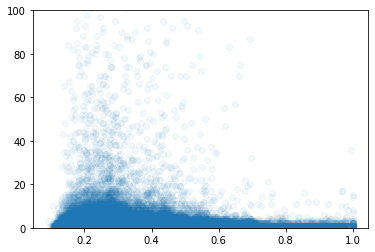

In [14]:
type(playlist_data.values())
# print(playlist_data.values())
xFollows = []
yDiversity = []
for pairs in playlist_data.values():
    xFollows.append(pairs[0])
    yDiversity.append(pairs[1])

matplotlib.pyplot.scatter(xFollows, yDiversity, alpha=.05)
matplotlib.pyplot.ylim(0, 100)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.]


<BarContainer object of 101 artists>

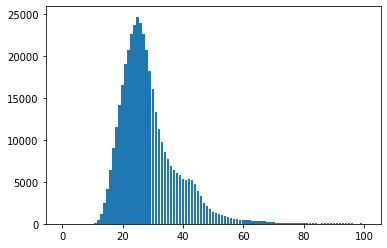

In [15]:
buckets = np.zeros(101)
for pairs in playlist_data.values():
    buckets[math.floor(pairs[0]*100)] += 1 
xcoords = np.zeros(101)
ct = 0
while ct < 101: 
    xcoords[ct] = ct
    ct += 1
 
print(xcoords)
matplotlib.pyplot.bar(xcoords,buckets)

# just trying to get a rough idea of how many playlists of each diversity there are

# ------------below is v2 diversity, it seems basically the same, can prob just do option 1 -----------


In [16]:

def custom_ideal_vector(genres_per_track, dim=N, g_ix=genre_to_ix):
    dist = np.zeros(dim)
    for track_genres in genres_per_track:
        for genre in track_genres:
            ix = g_ix[genre]
            dist[ix] = 1
    dist = dist * 1/(np.count_nonzero(dist))
    return dist 

In [17]:
playlist_dataV2 = {}
for file in playlist_files:
   # assert os.path.isfile(file) 
    with open(file, 'rb') as fp:
        data = json.load(fp)
    for playlist in data['playlists']:
        empty = False
        ID = playlist['pid']
        genres_per_track = []
        for track in playlist['tracks']:
            tID = track['track_uri']
            if len(songID_to_genres[tID]) != 0:
                genres_per_track.append(songID_to_genres[tID])
            else:
                empty = True
                break
        if empty:
            continue
        followers = playlist['num_followers']
        dist = calculate_playlist_vector(genres_per_track)
        custom_ideal_dist = custom_ideal_vector(genres_per_track)
        diversity = np.linalg.norm(custom_ideal_dist - dist,2)
        playlist_dataV2[ID] = (diversity, followers)

(0.0, 100.0)

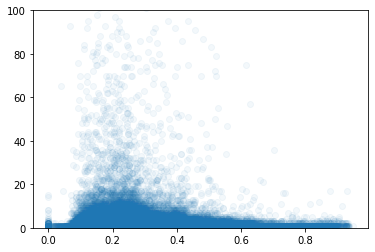

In [18]:
type(playlist_data.values())
# print(playlist_data.values())
xFollowsV2 = []
yDiversityV2 = []
for pairs in playlist_dataV2.values():
    xFollowsV2.append(pairs[0])
    yDiversityV2.append(pairs[1])

matplotlib.pyplot.scatter(xFollowsV2, yDiversityV2, alpha=.05)
matplotlib.pyplot.ylim(0, 100)